# Comparison of the Dif. coef. and alpha coefficient for two datasets

In [1]:
import pickle
import numpy as np
import pandas as pd
import ruptures as rpt
from pathlib import Path
from scipy.io import loadmat
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from step.data import *
from step.models import *

from tqdm.auto import tqdm
from fastai.vision.all import *
from scipy.optimize import curve_fit
import math
import mat73

# Analysis functions

In [2]:
def inst_MSD_fit(x, D): #Roger's MSD
    y = 2*2*D*x
    return y

def MSD(x, y):
    msd = np.zeros(len(x)-1)
    for i in range(len(x)-1):
        msd[i] = sum(np.square(np.sqrt(np.square(x[i:]-x[:len(x)-i])+np.square(y[i:]-y[:len(x)-i]))))/(len(x)-i)
    return msd

def MSD_fit(x, D, a):
    y = 2*2*D*x**a
    return y

def get_angle(a, b, c):
    vector_1 = b - a
    vector_2 = c - b 
    unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
    unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    ang = math.degrees(np.arccos(dot_product))
    d = np.cross(vector_2,vector_1)
    return ang if d < 0 else -ang

def dataset_angles(trajs):
    angles = []
    for traj in trajs:
        for a, b, c in zip(traj[:, :-2].transpose(), traj[:, 1:-1].transpose(), traj[:, 2:].transpose()):
            angles.append(get_angle(a, b, c))
    return angles

def confinement_radius(x, nm_per_pxl=160):
    """Compute the confinement radius of a trajectory segment."""
    cov = np.cov(x)
    e_vals, _ = np.linalg.eigh(cov)
    return 2 * nm_per_pxl * np.sqrt(e_vals.mean())

## Load the data
We start our analysis by loading the trajectories. Select one single tracking document. It needs to be a .mat file, of type cell. The first element of the cell needs to be a matrix of size number of trajectories x maximum number of frames, containing the x position of all localizations. There are NaN values in all other values. The second element has the same structure, but contains the y positions, and the third elements contains the distance of each localization to the nearest MCS structure boundary. 

In [7]:
##Processing for multiple Matlab variables
from tkinter import Tk, filedialog

In [8]:
# Create the Tkinter root window
root = Tk()
root.withdraw()
root.attributes('-topmost',True)

# Use the file dialog to select multiple files
data_paths = filedialog.askopenfilenames(
    title="Select MATLAB Files",
    filetypes=[("MATLAB files", "*.mat")],
    initialdir="E:\Shares\SMB_files\Jessica",
)

In [9]:
all_trajectories, all_close, all_trajectories_norm = [], [], []
for path in data_paths:
    file = mat73.loadmat(path)

    # Extract x and y data from the current file
    data_x, data_y = file["var1"][0:2]
    close = file["var1"][2]
    
    # Create a list to store trajectories for the current file
    trajectories, close_log, trajs_norm = [], [], []

    # Loop through x and y data and create trajectories
    for x, y, c in zip(data_x, data_y, close):
        x = torch.tensor(x[~np.isnan(x)])
        y = torch.tensor(y[~np.isnan(y)])
        c = torch.tensor(c[~np.isnan(c)])
        if len(x) > 12 and len(c) > 12:  # At least > 0
            if c.mean() < 40:
                traj = torch.stack((x - x[0], y - y[0])) #trajectories are centered to origin
                displ = traj[:,1:] - traj[:,:-1]
                std = displ.std(1).unsqueeze(1)
                displ_norm = displ/std #normalization by the std of displacements
                t_norm = torch.cat((torch.zeros_like(std), (displ_norm).cumsum(1)), dim=1)
                trajs_norm.append(t_norm)  #normalized trajectories for calculation of alpha
                trajectories.append(traj)
                close_log.append(c)

    # Append trajectories of the current file to the overall list
    all_trajectories.extend(trajectories)
    all_trajectories_norm.extend(trajs_norm)
    all_close.extend(close_log)

In [10]:
# Create the Tkinter root window for the second dataset
root = Tk()
root.withdraw()
root.attributes('-topmost',True)

# Use the file dialog to select multiple files
data_paths = filedialog.askopenfilenames(
    title="Select MATLAB Files",
    filetypes=[("MATLAB files", "*.mat")],
    initialdir="E:\Shares\SMB_files\Jessica",
)

In [11]:
all_trajectories2, all_close2, all_trajectories2_norm = [], [], []
for path in data_paths:
    file = mat73.loadmat(path)

    # Extract x and y data from the current file
    data_x, data_y = file["var1"][0:2]
    close = file["var1"][2]
    
    # Create a list to store trajectories for the current file
    trajectories, close_log, trajs_norm = [], [], []

    # Loop through x and y data and create trajectories
    for x, y, c in zip(data_x, data_y, close):
        x = torch.tensor(x[~np.isnan(x)])
        y = torch.tensor(y[~np.isnan(y)])
        c = torch.tensor(c[~np.isnan(c)])
        if len(x) > 12 and len(c) > 12:  # At least > 0
            if c.mean() < 40:
                traj = torch.stack((x - x[0], y - y[0])) #trajectories are centered to origin
                displ = traj[:,1:] - traj[:,:-1]
                std = displ.std(1).unsqueeze(1)
                displ_norm = displ/std #normalization by the std of displacements
                t_norm = torch.cat((torch.zeros_like(std), (displ_norm).cumsum(1)), dim=1)
                trajs_norm.append(t_norm) #normalized trajectories for calculation of alpha
                trajectories.append(traj)
                close_log.append(c)

    # Append trajectories of the current file to the overall list
    all_trajectories2.extend(trajectories)
    all_trajectories2_norm.extend(trajs_norm)
    all_close2.extend(close_log)

# Load model

In [12]:
model_dir = "../../models"
dim = 2

In [13]:
dls = DataLoaders.from_dsets([], []) # Empty train and validation datasets

# Diffusion coefficient
model_diff = LogXResAttn(dim, n_class=1, stem_szs=(64,), conv_blocks=[1, 1, 1],
                         block_szs=[128, 256, 512], dropout=0., pos_enc=False,
                         n_encoder_layers=4, dim_ff=512, nhead_enc=8,
                         linear_layers=[], norm=False, yrange=(-4.1, 2.1))
model_diff.to(default_device())

# Anomalous exponent
model_exp = XResAttn(dim, n_class=1, stem_szs=(32,), conv_blocks=[1, 1, 1],
                     block_szs=[128, 256, 512], dropout=0., pos_enc=False, n_encoder_layers=4,
                     dim_ff=512, nhead_enc=8, linear_layers=[])
model_exp.to(default_device())

# Create the learners
learn_diff = Learner(dls, model_diff, loss_func=L1LossFlat(), model_dir=model_dir)
learn_exp = Learner(dls, model_exp, loss_func=L1LossFlat(), model_dir=model_dir)

In [14]:
# Model for Dif. coef. 
learn_diff.load(f'logxresattn_bm_2d_1_to_5_cp_varlen_42')
learn_diff.model.eval();

In [15]:
# Model for alpha
learn_exp.load(f'xresattn_exp_2d_fbm_varlen')
learn_exp.model.eval();

# Get predictions

In [16]:
def predict(model, x):
    return to_detach(model(x.cuda().T.unsqueeze(0).float()).squeeze())

In [17]:
# Prediction set 1
# Traj longer than 20 frames get evaluated with STEP
constant_value = torch.tensor(np.log10(0.1567**2/0.01), dtype=torch.float32)
frame_rate = 0.01
pred_a, pred_d, tamsd_dif, tamsd_alpha = [], [], [], []
for traj, traj_n, c in zip(all_trajectories, all_trajectories_norm, all_close):
    #Prediction
    pred = predict(learn_exp.model, traj_n)
    pred_a.append(pred)
    pred = predict(learn_diff.model, traj)
    pred_d.append(pred + constant_value)
    #TAMSD
    x, y = traj[0], traj[1]
    msd = MSD(x,y)
    t = np.arange(0,int(len(msd)))
    inst_parameters, inst_covariance = curve_fit(inst_MSD_fit, t[0:4], msd[0:4])
    parameters, covariance = curve_fit(MSD_fit, t[0:round(len(x)*0.3)], msd[0:round(len(x)*0.3)])
    D_tamsd = np.log10(inst_parameters[0]) + constant_value.numpy()
    a = parameters[1]
    tamsd_dif.append(D_tamsd)
    tamsd_alpha.append(a)

C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_34460\286169932.py:12: RuntimeWarning: divide by zero encountered in power
  y = 2*2*D*x**a


In [18]:
# Prediction set 2
# Traj longer than 20 frames get evaluated with STEP
constant_value = torch.tensor(np.log10(0.1567**2/0.01), dtype=torch.float32)
pred_a2, pred_d2, tamsd_dif2, tamsd_alpha2 = [], [], [], []
for traj, traj_n, c in zip(all_trajectories2, all_trajectories2_norm, all_close2):
    #Prediction
    length = len(traj[0])
    pred = predict(learn_exp.model, traj_n)
    pred_a2.append(pred)
    pred = predict(learn_diff.model, traj)
    pred_d2.append(pred + constant_value)
    #TAMSD
    x, y = traj[0], traj[1]
    msd = MSD(x,y)
    t = np.arange(0,int(len(msd)))
    inst_parameters, inst_covariance = curve_fit(inst_MSD_fit, t[0:4], msd[0:4])
    parameters, covariance = curve_fit(MSD_fit, t[0:round(len(x)*0.3)], msd[0:round(len(x)*0.3)])
    D_tamsd = np.log10(inst_parameters[0]) + constant_value.numpy()
    a = parameters[1]
    tamsd_dif2.append(D_tamsd)
    tamsd_alpha2.append(a)

C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_34460\286169932.py:12: RuntimeWarning: divide by zero encountered in power
  y = 2*2*D*x**a
C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_34460\298051849.py:16: OptimizeWarning: Covariance of the parameters could not be estimated
  parameters, covariance = curve_fit(MSD_fit, t[0:round(len(x)*0.3)], msd[0:round(len(x)*0.3)])


# Visualization of single trajectory predictions
Change the value of idx to visualize the different trajectories, with coloured steps according to the alpha coefficient (left) or the diffusion coefficient (right). 

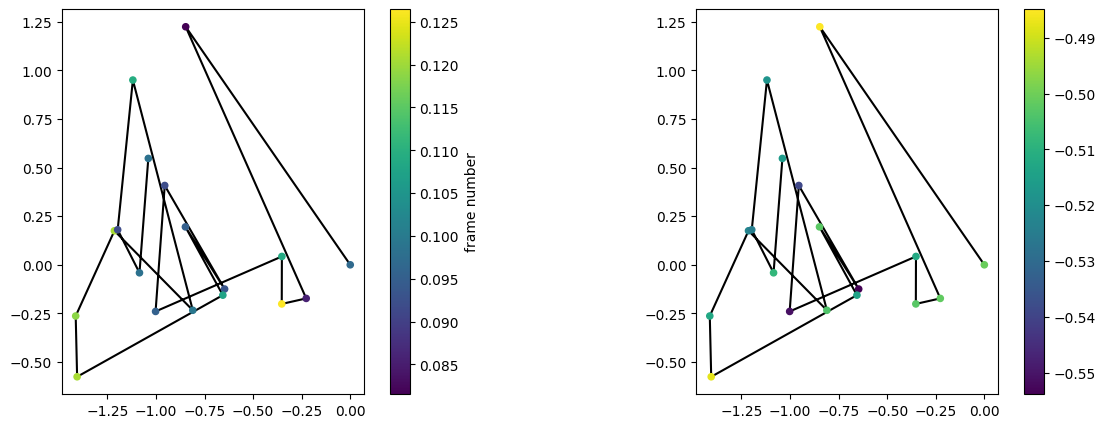

In [27]:
#Representation of values in space
idx = 10
colors1 = (pred_a[idx].numpy())[:-1]
colors2 = pred_d[idx].numpy()
x_coords = (all_trajectories[idx][0].numpy())[:-1]
y_coords = (all_trajectories[idx][1].numpy())[:-1]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(x_coords, y_coords, color='black', zorder=1)
sc1 = axes[0].scatter(x_coords, y_coords, c=colors1, cmap='viridis', s=20)
cbar1 = plt.colorbar(sc1, ax=axes[0])  # Use plt.colorbar with ax parameter
cbar1.set_label('frame number')

axes[1].plot(x_coords, y_coords, color='black', zorder=1)
sc2 = axes[1].scatter(x_coords, y_coords, c=colors2, cmap='viridis', s=20)
cbar2 = plt.colorbar(sc2, ax=axes[1])  # Use plt.colorbar with ax parameter

for ax in axes:
    ax.set_aspect('equal')

plt.show()


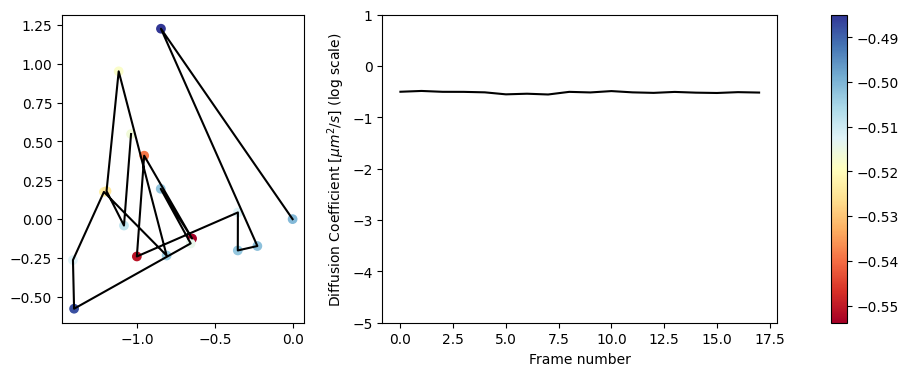

In [36]:
# Visualization of the change in diff. coef.
idx = 10
colors = pred_d[idx].numpy()
x_coords = (all_trajectories[idx][0].numpy())[:-1]
y_coords = (all_trajectories[idx][1].numpy())[:-1]
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].plot(x_coords, y_coords, color='black')
cm1 = matplotlib.colormaps['RdYlBu']
sc1 = axes[0].scatter(x_coords, y_coords, c=colors, cmap=cm1)
cbar1 = plt.colorbar(sc1, ax=axes)
axes[1].plot(pred_d[idx], color='black')
axes[1].set_ylim(-5, 1)
axes[1].set_ylabel('Diffusion Coefficient [$\mu m^2/s$] (log scale)')
axes[1].set_xlabel('Frame number')
axes[0].set_aspect('equal')

# Comparison between both datasets (frame-wise values)
These are the step-by-step values provided by STEP. 

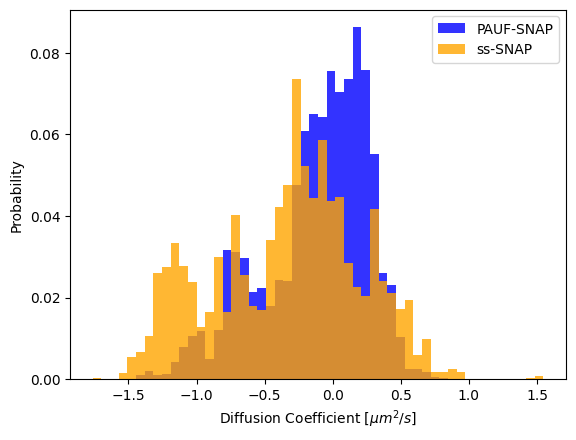

In [38]:
#Representation of Dif. Coef. for both datasets
data1 = torch.cat(pred_d).numpy()
data2 = torch.cat(pred_d2).numpy()
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
num_bins = min(num_bins1, num_bins2)
#Determine bin edges
min_value = min(data1.min(), data2.min())
max_value = max(data1.max(), data2.max())
bin_edges = np.linspace(min_value, max_value, num_bins + 1)
# Compute histograms to get the counts
counts1, _ = np.histogram(data1, bins=bin_edges)
counts2, _ = np.histogram(data2, bins=bin_edges)
# Calculate the relative probability for each bin
relative_probs1 = counts1 / counts1.sum()
relative_probs2 = counts2 / counts2.sum()
# Plot the histograms
plt.bar(bin_edges[:-1], relative_probs1, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='blue', label='PAUF-SNAP', align='edge')
plt.bar(bin_edges[:-1], relative_probs2, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='orange', label='ss-SNAP', align='edge')
plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('Probability')
plt.legend()

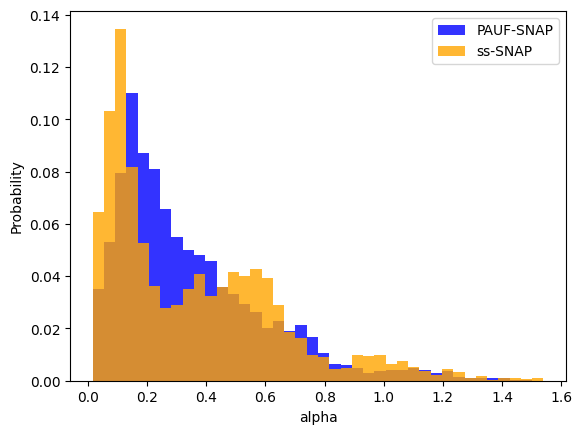

In [39]:
#Representation of alpha for both datasets
data1 = torch.cat(pred_a).numpy()
data2 = torch.cat(pred_a2).numpy()
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
#num_bins = min(num_bins1, num_bins2)
num_bins = 40
#Determine bin edges
min_value = min(data1.min(), data2.min())
max_value = max(data1.max(), data2.max())
bin_edges = np.linspace(min_value, max_value, num_bins + 1)
# Compute histograms without density=True to get the counts
counts1, _ = np.histogram(data1, bins=bin_edges)
counts2, _ = np.histogram(data2, bins=bin_edges)
# Calculate the relative probability for each bin
relative_probs1 = counts1 / counts1.sum()
relative_probs2 = counts2 / counts2.sum()
# Plot the histograms
plt.bar(bin_edges[:-1], relative_probs1, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='blue', label='PAUF-SNAP', align='edge')
plt.bar(bin_edges[:-1], relative_probs2, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='orange', label='ss-SNAP', align='edge')
plt.xlabel('alpha')
plt.ylabel('Probability')
plt.legend()

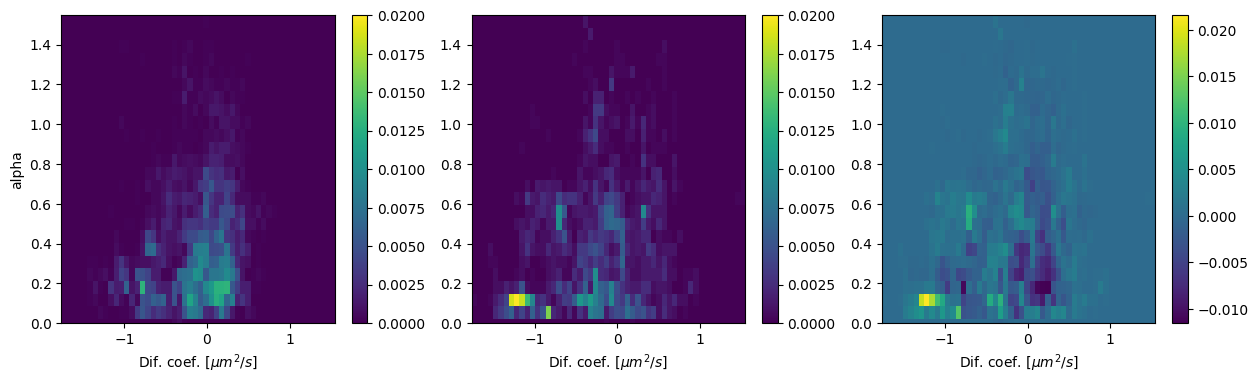

In [47]:
# Relationship diff. coef. and alpha
# Process data
data3 = torch.cat(pred_d2).numpy()
modified_tensors = [tensor[:-1] for tensor in pred_a2] #eliminate the last value
data4 = torch.cat(modified_tensors).numpy()
data1 = torch.cat(pred_d).numpy()
modified_tensors2 = [tensor[:-1] for tensor in pred_a] #eliminate the last value
data2 = torch.cat(modified_tensors2).numpy()

# Define the number of bins for each variable
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
num_bins3 = int(np.sqrt(len(data3)))
num_bins4 = int(np.sqrt(len(data4)))
chosen_bin_size = min(num_bins1, num_bins2, num_bins3, num_bins4)
data_range = [min(data1.min(), data2.min(), data3.min(), data4.min()), max(data1.max(), data2.max(), data3.max(), data4.max())]
bins = np.linspace(data_range[0], data_range[1], chosen_bin_size + 1)

# Compute the 2D histogram
hist_2d_1, xedges, yedges = np.histogram2d(data2, data1, bins=bins)

# Normalization
total_data_points = np.sum(hist_2d_1)
#total_data_points = hist_2d_1.sum(axis=1, keepdims=True)  # Sum across rows
hist_2d_normalized1 = hist_2d_1 / total_data_points

# Compute the 2D histogram
hist_2d_2, xedges, yedges = np.histogram2d(data4, data3, bins=bins)

# Normalization
total_data_points = np.sum(hist_2d_2)
#total_data_points = hist_2d_2.sum(axis=1, keepdims=True)  # Sum across rows
hist_2d_normalized2 = hist_2d_2 / total_data_points

#Subtraction of the histograms
hist_2d_diff = hist_2d_normalized2 - hist_2d_normalized1

#Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
im0 = axes[0].imshow(hist_2d_normalized1, cmap='viridis', interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], vmin=0, vmax=0.02)
im1 = axes[1].imshow(hist_2d_normalized2, cmap='viridis', interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], vmin=0, vmax=0.02)
im2 = axes[2].imshow(hist_2d_diff, cmap='viridis', interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
axes[0].set_ylabel('alpha')
axes[0].set_xlabel('Dif. coef. [$\mu m^2/s$]')
axes[1].set_xlabel('Dif. coef. [$\mu m^2/s$]')
axes[2].set_xlabel('Dif. coef. [$\mu m^2/s$]')
axes[0].set_ylim(0, data_range[1])
axes[1].set_ylim(0, data_range[1])
axes[2].set_ylim(0, data_range[1])
cbar0 = fig.colorbar(im0, ax=axes[0])
cbar1 = fig.colorbar(im1, ax=axes[1])
cbar2 = fig.colorbar(im2, ax=axes[2])
for ax in axes:
    ax.set_aspect('auto')

In [89]:
## Classify and calculate the probabilities of the data falling into the combinations of specified ranges for both the diffusion 
#coefficient  and alpha
#Define bin ranges
dif_coef_bins = [-3, -0.5, 1]  # Ranges for Dif. Coef.
alpha_bins = [0, 0.2, 0.6, 1.5]  # Ranges for alpha
#Data catagorization according to bins
data1 = np.array(torch.cat(pred_d).numpy())
modified_tensors = [tensor[:-1] for tensor in pred_a] #eliminate the last value
data2 = torch.cat(modified_tensors).numpy()
dif_coef_indices = np.digitize(data1, bins=dif_coef_bins)
alpha_indices = np.digitize(data2, bins=alpha_bins)

# Frequencies for each bin combination
count_matrix = np.zeros((len(dif_coef_bins), len(alpha_bins))) #initialize a 2D array to count frequencies
for i in range(1, len(dif_coef_bins)+1):
    for j in range(1, len(alpha_bins)+1):
        count_matrix[i-1, j-1] = np.sum((dif_coef_indices == i) & (alpha_indices == j))

# Normalize the counts to get probabilities
total_counts = np.sum(count_matrix)
probability_matrix = count_matrix / total_counts
print(len(data1))
print(count_matrix)

4695
[[ 437.  406.   49.    0.]
 [1221. 1900.  682.    0.]
 [   0.    0.    0.    0.]]


Prob(Dif. Coef. in (-3, -0.5) and alpha in (0, 0.2)): 0.09
Prob(Dif. Coef. in (-3, -0.5) and alpha in (0.2, 0.6)): 0.09
Prob(Dif. Coef. in (-3, -0.5) and alpha in (0.6, 1.5)): 0.01
Prob(Dif. Coef. in (-0.5, 1) and alpha in (0, 0.2)): 0.26
Prob(Dif. Coef. in (-0.5, 1) and alpha in (0.2, 0.6)): 0.40
Prob(Dif. Coef. in (-0.5, 1) and alpha in (0.6, 1.5)): 0.15


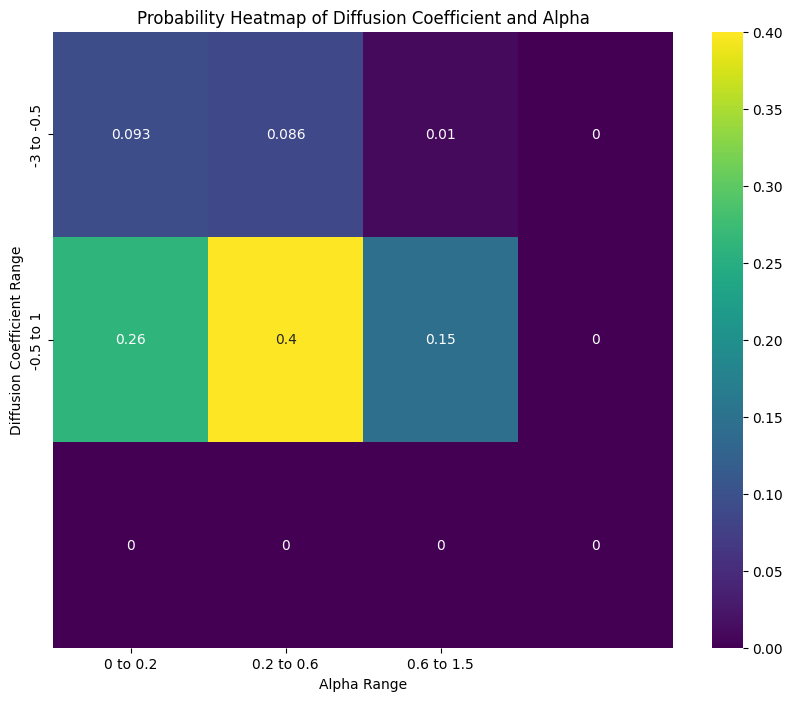

In [91]:
# Print probabilities
for i, dif_range in enumerate(zip(dif_coef_bins[:-1], dif_coef_bins[1:])):
    for j, alpha_range in enumerate(zip(alpha_bins[:-1], alpha_bins[1:])):
        print(f"Prob(Dif. Coef. in {dif_range} and alpha in {alpha_range}): {probability_matrix[i, j]:.2f}")
# Visualization
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(probability_matrix, annot=True, cmap="viridis", vmin=0, vmax=0.4, xticklabels=[f"{b[0]} to {b[1]}" for b in zip(alpha_bins[:-1], alpha_bins[1:])],
            yticklabels=[f"{b[0]} to {b[1]}" for b in zip(dif_coef_bins[:-1], dif_coef_bins[1:])])
plt.xlabel("Alpha Range")
plt.ylabel("Diffusion Coefficient Range")
plt.title("Probability Heatmap of Diffusion Coefficient and Alpha")
plt.show()

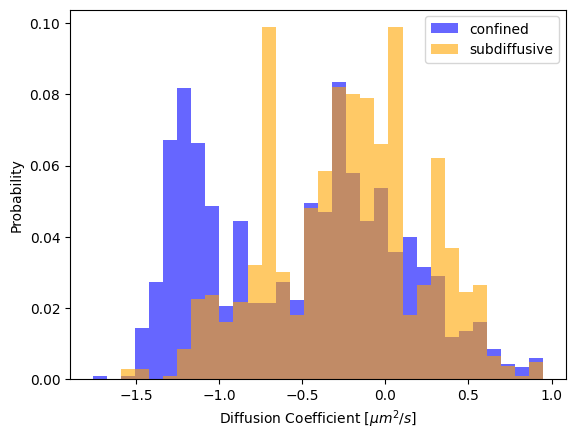

In [51]:
#Dif. coef. of highly confined trajectories (0 to 0.2)
data_confined, data_subd = [], []
for preda, predd in zip(pred_a2, pred_d2):
    preda = preda[:-1]
    # Bolean indexing
    conf = predd[preda < 0.2]
    subd = predd[(preda > 0.2) & (preda < 0.6)]
    #Append the data
    data_confined.append(conf)
    data_subd.append(subd)
data_confined = torch.cat(data_confined).numpy()
data_subd = torch.cat( data_subd).numpy()
#Representation close and far 1 dataset
#Determine number of bins
num_bins1 = int(np.sqrt(len(data_confined)))
num_bins2 = int(np.sqrt(len(data_subd)))
num_bins = min(num_bins1, num_bins2)
#Determine bin edges
min_value = min(data_confined.min(), data_subd.min())
max_value = max(data_confined.max(), data_subd.max())
bin_edges = np.linspace(min_value, max_value, num_bins + 1)
# Compute histograms without density=True to get the counts
counts1, _ = np.histogram(data_confined, bins=bin_edges)
counts2, _ = np.histogram(data_subd, bins=bin_edges)
# Calculate the relative probability for each bin
relative_probs1 = counts1 / counts1.sum()
relative_probs2 = counts2 / counts2.sum()
# Plot the histograms
plt.bar(bin_edges[:-1], relative_probs1, width=bin_edges[1] - bin_edges[0], alpha=0.6, color='blue', label='confined', align='edge')
plt.bar(bin_edges[:-1], relative_probs2, width=bin_edges[1] - bin_edges[0], alpha=0.6, color='orange', label='subdiffusive', align='edge')
plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
#plt.ylim(0, 0.11)
plt.ylabel('Probability')
plt.legend()
plt.show()

## Distance to MCS
Step-wise predictions in the context of the MCS distance. 

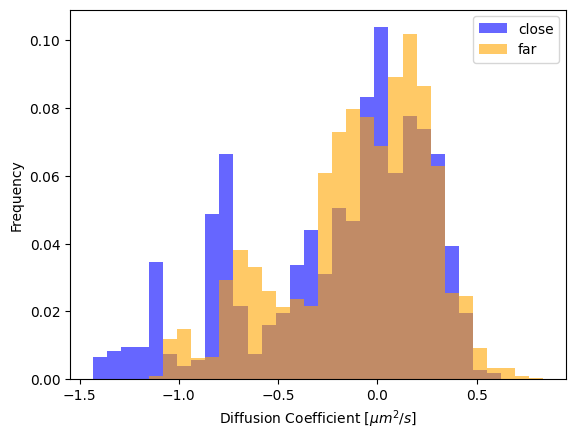

In [52]:
#Filtering of data by close and far, Dif. coef. It is considered close when the distance is smaller than 3 pixels, and far, when it is higher than 3 pixels. 
#Localizations that are on top of the BiFC signal are displayed as negative distances to the closest boundaries of the structure. 
data_close, data_far = [], []
for pred, c in zip(pred_d, all_close):
    # Duplicate the last value of preds to match the length of c
    last_pred_value = pred[-1]
    filled_values = torch.full((len(c) - len(pred),), last_pred_value, dtype=pred.dtype, device=pred.device)
    pred = torch.cat((pred, filled_values), dim=0)
    # Bolean indexing
    close_pred = pred[c < 3]
    far_pred = pred[c > 3]
    #Append the data
    data_close.append(close_pred)
    data_far.append(far_pred)
data_close = torch.cat(data_close).numpy()
data_far = torch.cat(data_far).numpy()

#Representation close and far 1 dataset
#Determine number of bins
data1 = data_close
data2 = data_far
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
num_bins = min(num_bins1, num_bins2)
#Determine bin edges
min_value = min(data1.min(), data2.min())
max_value = max(data1.max(), data2.max())
bin_edges = np.linspace(min_value, max_value, num_bins + 1)
# Compute histograms without density=True to get the counts
counts1, _ = np.histogram(data1, bins=bin_edges)
counts2, _ = np.histogram(data2, bins=bin_edges)
# Calculate the relative probability for each bin
relative_probs1 = counts1 / counts1.sum()
relative_probs2 = counts2 / counts2.sum()
# Plot the histograms
plt.bar(bin_edges[:-1], relative_probs1, width=bin_edges[1] - bin_edges[0], alpha=0.6, color='blue', label='close', align='edge')
plt.bar(bin_edges[:-1], relative_probs2, width=bin_edges[1] - bin_edges[0], alpha=0.6, color='orange', label='far', align='edge')
plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('Frequency')
plt.legend()

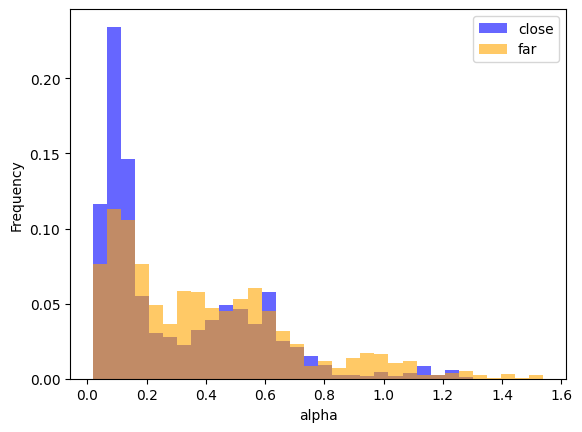

In [56]:
#Filtering of data by close and far, alpha. It is considered close when the distance is smaller than 3 pixels, and far, when it is higher than 3 pixels. 
#Localizations that are on top of the BiFC signal are displayed as negative distances to the closest boundaries of the structure.
data_close, data_far = [], []
for pred, c in zip(pred_a2, all_close2):
    # Bolean indexing
    close_pred = pred[c < 3]
    far_pred = pred[c > 3]
    #Append the data
    data_close.append(close_pred)
    data_far.append(far_pred)
data_close = torch.cat(data_close).numpy()
data_far = torch.cat(data_far).numpy()

#Representation close and far 1 dataset
#Determine number of bins
data1 = data_close
data2 = data_far
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
num_bins = min(num_bins1, num_bins2)
#Determine bin edges
min_value = min(data1.min(), data2.min())
max_value = max(data1.max(), data2.max())
bin_edges = np.linspace(min_value, max_value, num_bins + 1)
# Compute histograms without density=True to get the counts
counts1, _ = np.histogram(data1, bins=bin_edges)
counts2, _ = np.histogram(data2, bins=bin_edges)
# Calculate the relative probability for each bin
relative_probs1 = counts1 / counts1.sum()
relative_probs2 = counts2 / counts2.sum()
# Plot the histograms
plt.bar(bin_edges[:-1], relative_probs1, width=bin_edges[1] - bin_edges[0], alpha=0.6, color='blue', label='close', align='edge')
plt.bar(bin_edges[:-1], relative_probs2, width=bin_edges[1] - bin_edges[0], alpha=0.6, color='orange', label='far', align='edge')
plt.xlabel('alpha')
plt.ylabel('Frequency')
plt.legend()

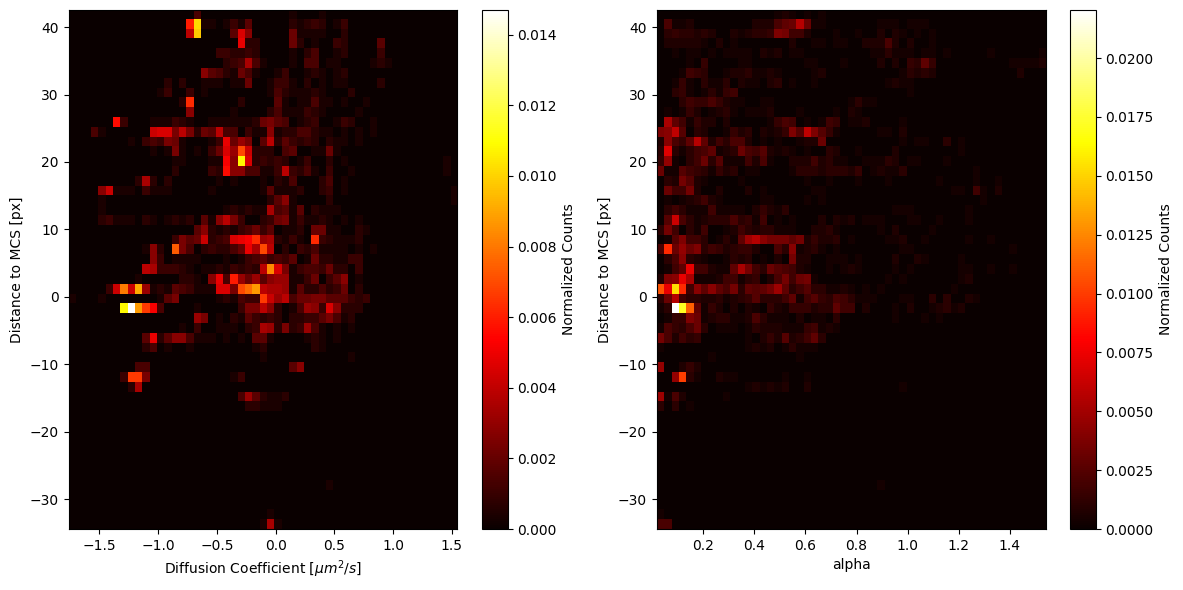

In [55]:
#Representation D and alpha vs. distance to MCS
# Process data
data1, data3 = [], []
for pred, pred2 in zip(pred_d2, pred_a2):
    # Duplicate the last value of pred
    last_pred_value1 = pred[-1].unsqueeze(0)
    pred = torch.cat((pred, last_pred_value1), dim=0)
    #Concatenate
    data1.append(pred)
    data3.append(pred2)
data1 =  torch.cat(data1).numpy()
data2 = torch.cat(all_close2).numpy()
data3 = torch.cat(data3).numpy()

# Binning
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
num_bins3 = int(np.sqrt(len(data3)))
chosen_bin_size = min(num_bins1, num_bins2, num_bins3)
data1_range = (min(data1), max(data1))
data2_range = (min(data2), max(data2))
data3_range = (min(data3), max(data3))
bins1 = [np.linspace(data2_range[0], data2_range[1], chosen_bin_size + 1), 
        np.linspace(data1_range[0], data1_range[1], chosen_bin_size + 1)]
bins2 = [np.linspace(data2_range[0], data2_range[1], chosen_bin_size + 1), 
        np.linspace(data3_range[0], data3_range[1], chosen_bin_size + 1)]

#Plot
hist_2d_1, xedges, yedges = np.histogram2d(data2, data1, bins=bins1)
total_data_points = np.sum(hist_2d_1)
hist_2d_normalized1 = hist_2d_1 / total_data_points
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
im1 = axs[0].imshow(hist_2d_normalized1, cmap='hot', interpolation='nearest', origin='lower', extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]])
axs[0].set_xlabel('Diffusion Coefficient [$\mu m^2/s$]')
axs[0].set_ylabel('Distance to MCS [px]')
axs[0].set_aspect('auto')
cbar1 = fig.colorbar(im1, ax=axs[0], orientation='vertical')
cbar1.set_label('Normalized Counts')
hist_2d_2, xedges, yedges = np.histogram2d(data2, data3, bins=bins2)
total_data_points = np.sum(hist_2d_2)
hist_2d_normalized2 = hist_2d_2 / total_data_points
im2 = axs[1].imshow(hist_2d_normalized2, cmap='hot', interpolation='nearest', origin='lower', extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]])
axs[1].set_xlabel('alpha')
axs[1].set_ylabel('Distance to MCS [px]')
axs[1].set_aspect('auto')
#axs[1].set_ylim(-10,10)
#axs[0].set_ylim(-10,10)
cbar2 = fig.colorbar(im2, ax=axs[1], orientation='vertical')
cbar2.set_label('Normalized Counts')
plt.tight_layout()

In [94]:
#Plot by distance to MCS
alpha_bins = [0, 0.2, 0.6, 1.5]
alpha_labels = ['confined', 'subdiffusive', 'Brownian']
dif_coef_bins = [-3, -0.5, 1]
dif_coef_labels = ['slow', 'fast']

def classify_predictions(alphas, ds):
    alpha_indices = np.digitize(alphas, alpha_bins) - 1
    ds_indices = np.digitize(ds, dif_coef_bins) - 1
    groups = []
    for a_idx, d_idx in zip(alpha_indices, ds_indices):
        alpha_part = alpha_labels[a_idx] if 0 <= a_idx < len(alpha_labels) else 'Unknown'
        dif_part = dif_coef_labels[d_idx] if 0 <= d_idx < len(dif_coef_labels) else 'Unknown'
        group = f"{alpha_part}-{dif_part}" if 'Unknown' not in (alpha_part, dif_part) else 'Unknown'
        groups.append(group)
    return groups

In [95]:
# Flatten the lists of tensors
all_close_flat = np.concatenate([c[:-1].numpy() for c in all_close]) #we eliminate the last value from each traj
all_close_flat *= 0.1567 #multiply by the pixel size (nm)
pred_d_flat = torch.cat(pred_d).numpy()
pred_a_flat = np.concatenate([p[:-1].numpy() for p in pred_a]) #we eliminate the last value from each traj

# Assign each proximity value to a group based on pred_d and pred_a
groups = classify_predictions(pred_a_flat, pred_d_flat)

# Create the DataFrame
df = pd.DataFrame({
    'Value': all_close_flat,
    'Group': groups
    })

#Remove entries classified as 'Unknown'
df = df[df['Group'] != 'Unknown']

# Optionally, re-establish the categorical type for plotting if needed
unique_groups = sorted(set(df['Group']))  # Update unique groups after filtering
df['Group'] = pd.Categorical(df['Group'], categories=unique_groups, ordered=True)

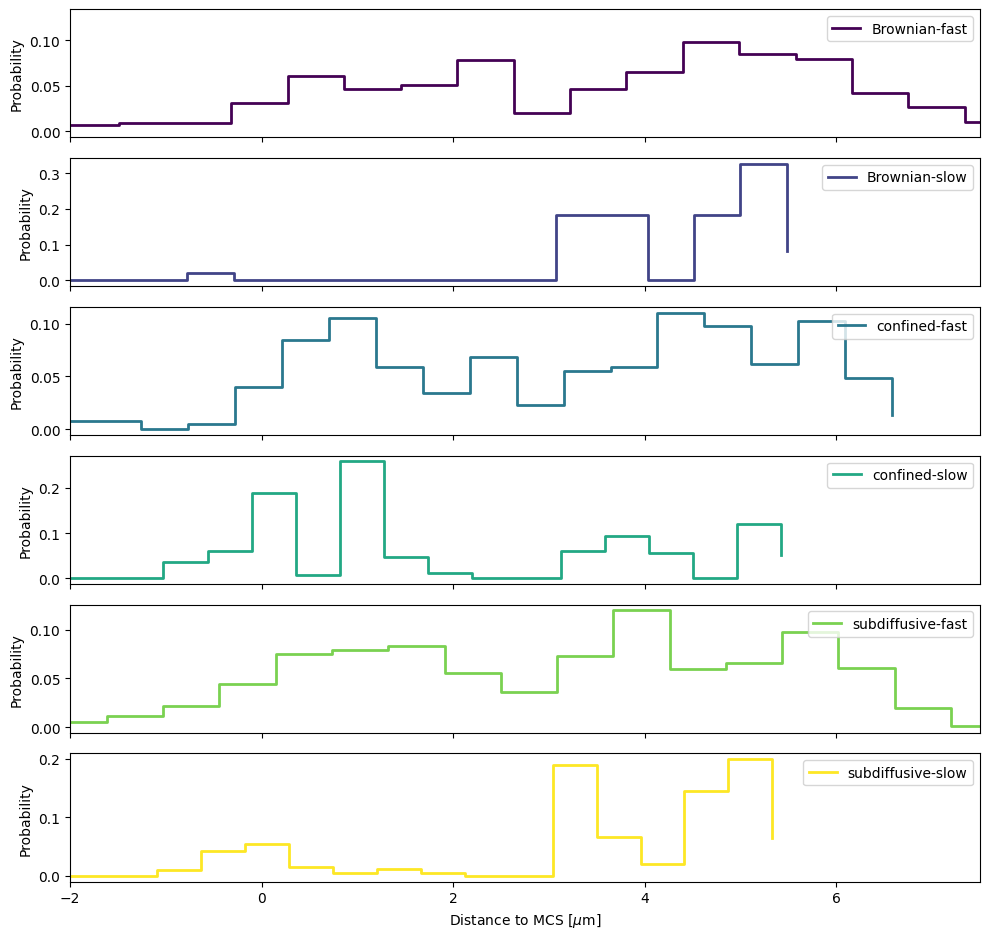

In [96]:
# Setup the colors and plot
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_groups)))
fig, axes = plt.subplots(nrows=len(unique_groups), figsize=(10, 10), sharex=True)
if len(unique_groups) == 1:
    axes = [axes]

for ax, (group, color) in zip(axes, zip(unique_groups, colors)):
    subset = df[df['Group'] == group]['Value']
    counts, bins = np.histogram(subset, bins=30)  # Adjust bin count as needed
    probabilities = counts / counts.sum()
    ax.step(bins[:-1], probabilities, where='post', color=color, label=f"{group}", linewidth=2)
    ax.set_ylabel('Probability')
    ax.legend(loc='upper right')

plt.xlabel('Distance to MCS [$\mu$m]')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.xlim(-2,7.5)
plt.show()

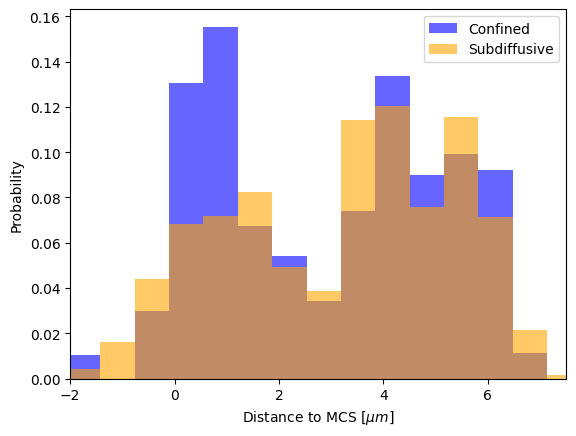

In [49]:
#Dif. coef. of highly confined trajectories (0 to 0.2)
data_confined, data_subd, data_Brow = [], [], []
for preda, c in zip(pred_a, all_close):
    # Bolean indexing
    conf = c[preda < 0.2]
    subd = c[(preda > 0.2) & (preda < 0.6)]
    brow = c[preda > 0.6]
    #Append the data
    data_confined.append(conf)
    data_subd.append(subd)
    data_Brow.append(brow)
data_confined = torch.cat(data_confined).numpy() * 0.1567
data_subd = torch.cat(data_subd).numpy() * 0.1567
data_Brow = torch.cat(data_Brow).numpy() * 0.1567
#Determine number of bins
num_bins1 = int(np.sqrt(len(data_confined)))
num_bins2 = int(np.sqrt(len(data_subd)))
num_bins3 = int(np.sqrt(len(data_Brow)))
num_bins = min(num_bins1, num_bins2, num_bins3)
#Determine bin edges
min_value = min(data_confined.min(), data_subd.min(), data_Brow.min())
max_value = max(data_confined.max(), data_subd.max(), data_Brow.max())
bin_edges = np.linspace(min_value, max_value, num_bins + 1)
# Compute histograms without density=True to get the counts
counts1, _ = np.histogram(data_confined, bins=bin_edges)
counts2, _ = np.histogram(data_subd, bins=bin_edges)
counts3, _ = np.histogram(data_Brow, bins=bin_edges)
# Calculate the relative probability for each bin
relative_probs1 = counts1 / counts1.sum()
relative_probs2 = counts2 / counts2.sum()
relative_probs3 = counts3 / counts3.sum()
# Plot the histograms
plt.bar(bin_edges[:-1], relative_probs1, width=bin_edges[1] - bin_edges[0], alpha=0.6, color='blue', label='Confined', align='edge')
plt.bar(bin_edges[:-1], relative_probs2, width=bin_edges[1] - bin_edges[0], alpha=0.6, color='orange', label='Subdiffusive', align='edge')
#plt.bar(bin_edges[:-1], relative_probs3, width=bin_edges[1] - bin_edges[0], alpha=0.6, color='yellow', label='Brownian', align='edge')
plt.xlabel('Distance to MCS [$\mu m$]')
plt.xlim(-2, 7.5)
#plt.ylim(0, 0.07)
plt.ylabel('Probability')
plt.legend()
plt.show()

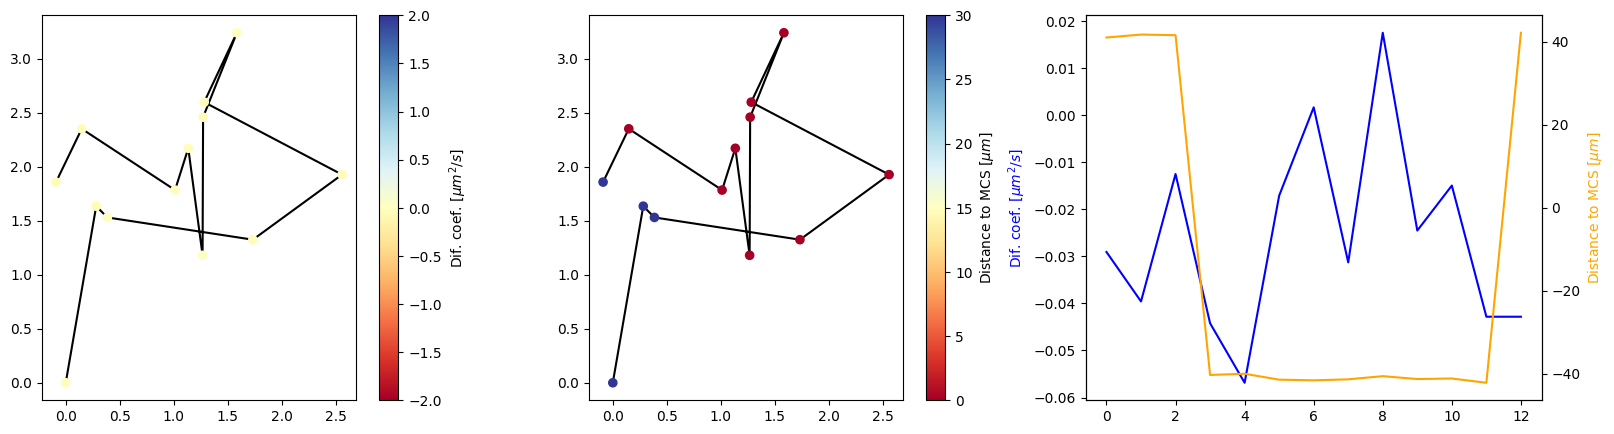

In [57]:
# Visualization of single trajectory diffusion coefficient and distance to MCS. 
idx = 16
traj = all_trajectories[idx]
x = traj[0]
y = traj[1]
last_pred_value = pred_d[idx][-1] # Duplicate the last value of preds to match the length of x and y
preds_idx_extended = np.append(pred_d[idx], np.full(len(x) - len(pred_d[idx]), last_pred_value))
close = all_close[idx]
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
cm1 = matplotlib.colormaps['RdYlBu']
axes[0].plot(x, y, color='black', zorder=1)
axes[1].plot(x, y, color='black', zorder=1)
sc1 = axes[0].scatter(x, y, c=preds_idx_extended, s=35, cmap=cm1, zorder=2, vmin=-2, vmax=2)
sc2 = axes[1].scatter(x, y, c=close, s=35, cmap=cm1, zorder=2, vmin=0, vmax=30)
axes2_twin = axes[2].twinx()
axes[2].plot(preds_idx_extended, color='blue')
axes2_twin.plot(close, color='orange')
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('Dif. coef. [$\mu m^2/s$]')
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Distance to MCS [$\mu m$]')
axes[2].set_ylabel('Dif. coef. [$\mu m^2/s$]', color='blue')
axes2_twin.set_ylabel('Distance to MCS [$\mu m$]', color='orange')
axes[0].set_aspect('equal')
axes[1].set_aspect('equal')

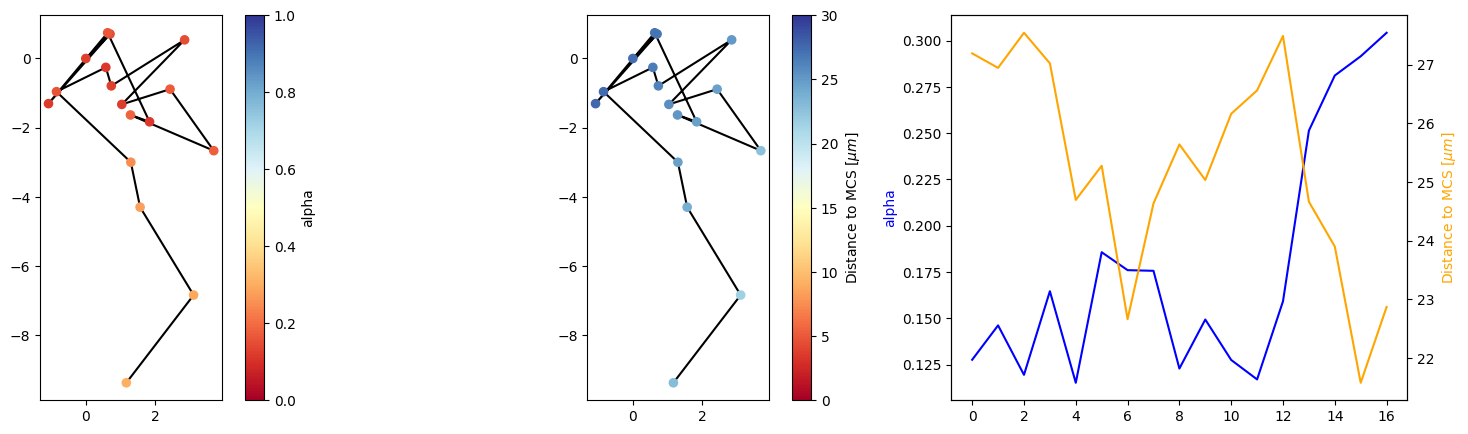

In [58]:
idx = 2
traj = all_trajectories[idx]
x = traj[0]
y = traj[1]
last_pred_value = pred_a[idx][-1] # Duplicate the last value of preds to match the length of x and y
preds_idx_extended = np.append(pred_a[idx], np.full(len(x) - len(pred_a[idx]), last_pred_value))
close = all_close[idx]
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
cm1 = matplotlib.colormaps['RdYlBu']
axes[0].plot(x, y, color='black', zorder=1)
axes[1].plot(x, y, color='black', zorder=1)
sc1 = axes[0].scatter(x, y, c=preds_idx_extended, s=35, cmap=cm1, zorder=2, vmin=0, vmax=1)
sc2 = axes[1].scatter(x, y, c=close, s=35, cmap=cm1, zorder=2, vmin=0, vmax=30)
axes2_twin = axes[2].twinx()
axes[2].plot(preds_idx_extended, color='blue')
axes2_twin.plot(close, color='orange')
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('alpha')
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Distance to MCS [$\mu m$]')
axes[2].set_ylabel('alpha', color='blue')
axes2_twin.set_ylabel('Distance to MCS [$\mu m$]', color='orange')
axes[0].set_aspect('equal')
axes[1].set_aspect('equal')

# Trajectory segmentation

In [59]:
def find_segments(pred1, pred2, traj, close, pen=1, **kwargs):
    import ruptures as rpt
    pred = np.column_stack((pred1, pred2)) #concatenate pred_d and pred_alpha
    alg = rpt.KernelCPD(**kwargs).fit(pred)
    cps = np.concatenate(([0], alg.predict(pen=pen)))
    segments, Ds, Ds_tamsd, alphas, alphas_tamsd, position, angles = [], [], [], [], [], [], []
    new_d, new_a = np.ones_like(pred1), np.ones_like(pred2)
    d_tamsd = np.ones_like(pred1)
    for i, j in zip(cps[:-1], cps[1:]): #iterate over each segment defined by consecutive cps
        segment = traj[:, i:j]
        alpha_seg, D_seg, loc = pred2[i:j].mean(), pred1[i:j].mean(), close[i:j].mean()
        new_d[i:j] *= D_seg
        new_a[i:j] *= alpha_seg
        #Fit the MSD curve
        x, y = traj[0], traj[1]
        msd = MSD(x,y)
        t = np.arange(0,int(len(msd)))
        inst_parameters, inst_covariance = curve_fit(inst_MSD_fit, t[0:4], msd[0:4]) #Roger's MSD
        parameters, covariance = curve_fit(MSD_fit, t[0:round(len(x)*0.3)], msd[0:round(len(x)*0.3)])
        D_tamsd = np.log10(inst_parameters[0]) + constant_value.numpy()
        a = parameters[1]
        d_tamsd[i:j] *= D_tamsd
        segments.append(segment)
        alphas.append(alpha_seg)
        Ds.append(D_seg)
        Ds_tamsd.append(D_tamsd)
        alphas_tamsd.append(a)
        position.append(loc)
        if np.abs(i-j) > 0:
            angl = (dataset_angles([segment])) #angle distribution
            angles.append(angl)
            
    return new_d, d_tamsd, new_a, segments, Ds, Ds_tamsd, alphas, alphas_tamsd, position, angles

In [69]:
seg_ds, seg_ds_tamsd, seg_angs, seg_alphas, trajs, new_Dif, new_alpha, new_tamsd, seg_alphas_tamsd, jumps_dif, jumps_alpha, location, cps_location = [], [], [], [], [], [], [], [], [], [], [], [], []
for traj, pred1, pred2, close in tqdm(zip(all_trajectories, pred_d, pred_a, all_close)):
    pred1 = pred1.numpy()
    pred2 = pred2.numpy()[:-1] #remove last value
    traj = np.concatenate([np.zeros((2, 1)), np.array([traj[0], traj[1]])], axis=1)
    out = find_segments(pred1, pred2, traj, close, min_size=4, pen=0.5) # previously min_size=10, pen=0.1
    new_d, d_tamsd, new_a, segments, d_seg, dtamsd_seg, alphas, alphas_tamsd, position, angles = out
    new_Dif.append(new_d)
    new_alpha.append(new_a)
    new_tamsd.append(d_tamsd)
    seg_ds.append(d_seg)
    seg_ds_tamsd.append(dtamsd_seg)
    seg_alphas_tamsd.append(alphas_tamsd)
    trajs.append(segments)
    seg_alphas.append(alphas)
    location.append(position)
    #Calculate changepoint diff and location
    diff_d = np.diff(new_d)  # Successive differences in new_d
    diff_a = np.diff(new_a)  # Successive differences in new_a
    jump_indices_d = np.where(np.abs(diff_d) > 0)[0]  # Indices of jumps in new_d
    jump_indices_a = np.where(np.abs(diff_a) > 0)[0]  # Indices of jumps in new_a
    jump_d = diff_d[jump_indices_d]
    jump_a = diff_a[jump_indices_d]
    cps_loc = close[jump_indices_d + 1]
    cps_location.append(cps_loc)
    jumps_dif.append(jump_d)
    jumps_alpha.append(jump_a)
    seg_angs.append(angles)

seg_ds = np.concatenate(seg_ds)
location = np.concatenate(location)
seg_ds_tamsd = np.concatenate(seg_ds_tamsd)
seg_alphas_tamsd = np.concatenate(seg_alphas_tamsd)
seg_alphas = np.concatenate(seg_alphas)
seg_lens = np.array([seg.shape[-1] for traj in trajs for seg in traj])
seg_radi = [[confinement_radius(seg) for seg in traj] for traj in trajs]
jumps_dif = np.concatenate(jumps_dif)
jumps_alpha = np.concatenate(jumps_alpha)
cps_location = np.concatenate(cps_location)

0it [00:00, ?it/s]

C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_34460\286169932.py:18: RuntimeWarning: invalid value encountered in divide
  unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_34460\286169932.py:12: RuntimeWarning: divide by zero encountered in power
  y = 2*2*D*x**a


In [67]:
seg_ds2, seg_ds_tamsd, seg_angs2, seg_alphas2, trajs2, new_Dif2, new_alpha2, new_tamsd2, seg_alphas_tamsd, jumps_dif2, jumps_alpha2, location2, cps_location2 = [], [], [], [], [], [], [], [], [], [], [], [], []
for traj, pred1, pred2, close in tqdm(zip(all_trajectories2, pred_d2, pred_a2, all_close2)):
    pred1 = pred1.numpy()
    pred2 = pred2.numpy()[:-1] #remove last value
    traj = np.concatenate([np.zeros((2, 1)), np.array([traj[0], traj[1]])], axis=1)
    out = find_segments(pred1, pred2, traj, close, min_size=4, pen=0.5) # previously min_size=10, pen=0.1
    new_d, d_tamsd, new_a, segments, d_seg, dtamsd_seg, alphas, alphas_tamsd, position, angles = out
    new_Dif2.append(new_d)
    new_alpha2.append(new_a)
    new_tamsd2.append(d_tamsd)
    seg_ds2.append(d_seg)
    seg_ds_tamsd.append(dtamsd_seg)
    seg_alphas_tamsd.append(alphas_tamsd)
    trajs2.append(segments)
    seg_alphas2.append(alphas)
    location2.append(position)
    #Calculate changepoint diff and location
    diff_d = np.diff(new_d)  # Successive differences in new_d
    diff_a = np.diff(new_a)  # Successive differences in new_a
    jump_indices_d = np.where(np.abs(diff_d) > 0)[0]  # Indices of jumps in new_d
    jump_indices_a = np.where(np.abs(diff_a) > 0)[0]  # Indices of jumps in new_a
    jump_d = diff_d[jump_indices_d]
    jump_a = diff_a[jump_indices_d]
    cps_loc = close[jump_indices_d + 1]
    cps_location2.append(cps_loc)
    jumps_dif2.append(jump_d)
    jumps_alpha2.append(jump_a)
    seg_angs2.append(angles)

seg_ds2 = np.concatenate(seg_ds2)
location2 = np.concatenate(location2)
seg_ds_tamsd = np.concatenate(seg_ds_tamsd)
seg_alphas_tamsd = np.concatenate(seg_alphas_tamsd)
seg_alphas2 = np.concatenate(seg_alphas2)
seg_lens = np.array([seg.shape[-1] for traj in trajs for seg in traj])
seg_radi = [[confinement_radius(seg) for seg in traj] for traj in trajs]
jumps_dif2 = np.concatenate(jumps_dif2)
jumps_alpha2 = np.concatenate(jumps_alpha2)
cps_location2 = np.concatenate(cps_location2)

0it [00:00, ?it/s]

C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_34460\286169932.py:18: RuntimeWarning: invalid value encountered in divide
  unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_34460\286169932.py:12: RuntimeWarning: divide by zero encountered in power
  y = 2*2*D*x**a
C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_34460\3895384645.py:19: OptimizeWarning: Covariance of the parameters could not be estimated
  parameters, covariance = curve_fit(MSD_fit, t[0:round(len(x)*0.3)], msd[0:round(len(x)*0.3)])


Text(0.5, 0, 'Frame number')

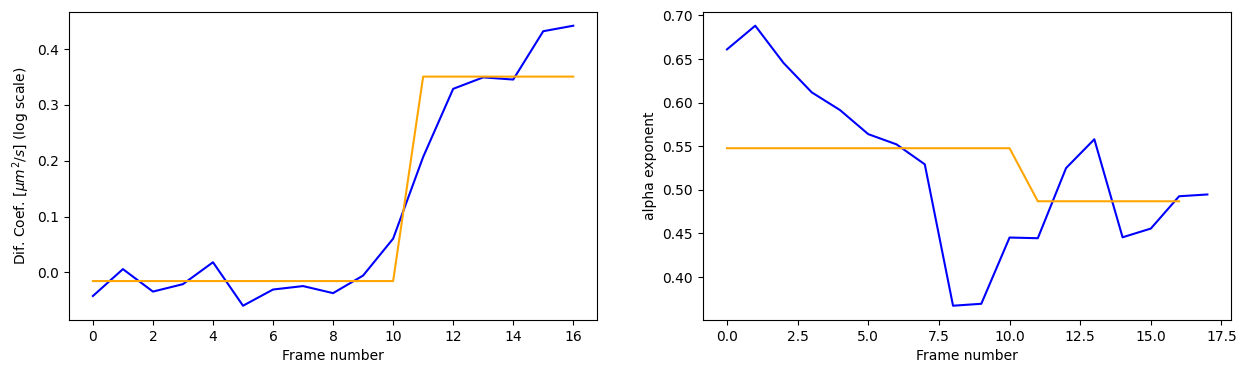

In [75]:
#Segmentation results. In yellow we have the value that has been assigned to the localizations after 
#the segmentation, which is the mean of the segment. 
idx = 5
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
axes[0].plot(pred_d[idx], color='blue')
axes[0].plot(new_Dif[idx], color='orange')
axes[0].set_ylabel('Dif. Coef. [$\mu m^2/s$] (log scale)')
axes[0].set_xlabel('Frame number')
axes[1].plot(pred_a[idx], color='blue')
axes[1].plot(new_alpha[idx], color='orange')
axes[1].set_ylabel('alpha exponent')
axes[1].set_xlabel('Frame number')

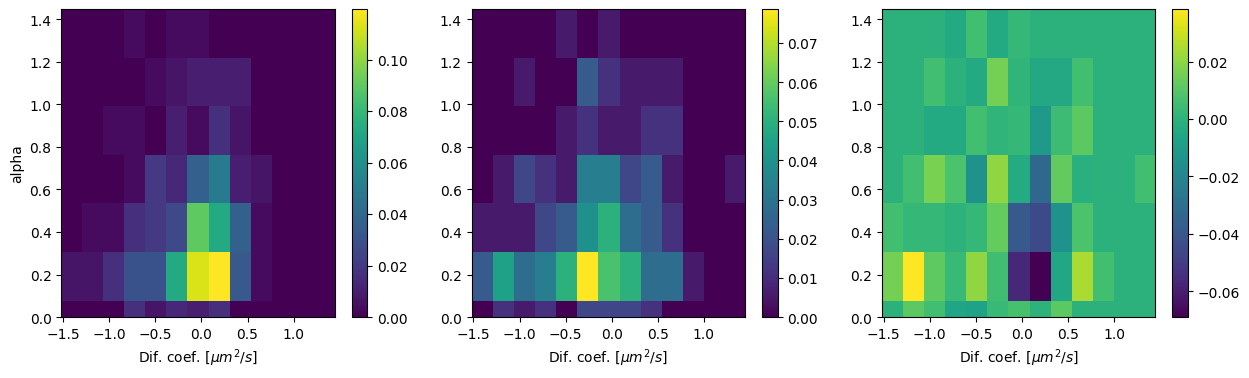

In [81]:
# Relationship diff. coef. and alpha. The first plot corresponds to the first dataset, the second plot is the second dataset, and the third plot is the diference between them. 
# Process data
data3 = seg_ds2
data4 = seg_alphas2
data1 = seg_ds
data2 = seg_alphas

# Define the number of bins for each variable
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
num_bins3 = int(np.sqrt(len(data3)))
num_bins4 = int(np.sqrt(len(data4)))
chosen_bin_size = min(num_bins1, num_bins2, num_bins3, num_bins4)
data_range = [min(data1.min(), data2.min(), data3.min(), data4.min()), max(data1.max(), data2.max(), data3.max(), data4.max())]
bins = np.linspace(data_range[0], data_range[1], chosen_bin_size + 1)

# Compute the 2D histogram
hist_2d_1, xedges, yedges = np.histogram2d(data2, data1, bins=bins)

# Normalization
total_data_points = np.sum(hist_2d_1)
#total_data_points = hist_2d_1.sum(axis=1, keepdims=True)  # Sum across rows
hist_2d_normalized1 = hist_2d_1 / total_data_points

# Compute the 2D histogram
hist_2d_2, xedges, yedges = np.histogram2d(data4, data3, bins=bins)

# Normalization
total_data_points = np.sum(hist_2d_2)
#total_data_points = hist_2d_2.sum(axis=1, keepdims=True)  # Sum across rows
hist_2d_normalized2 = hist_2d_2 / total_data_points

#Subtraction of the histograms
hist_2d_diff = hist_2d_normalized2 - hist_2d_normalized1

#Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
im0 = axes[0].imshow(hist_2d_normalized1, cmap='viridis', interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
im1 = axes[1].imshow(hist_2d_normalized2, cmap='viridis', interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
im2 = axes[2].imshow(hist_2d_diff, cmap='viridis', interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
axes[0].set_ylabel('alpha')
axes[0].set_xlabel('Dif. coef. [$\mu m^2/s$]')
axes[1].set_xlabel('Dif. coef. [$\mu m^2/s$]')
axes[2].set_xlabel('Dif. coef. [$\mu m^2/s$]')
axes[0].set_ylim(0, data_range[1])
axes[1].set_ylim(0, data_range[1])
axes[2].set_ylim(0, data_range[1])
cbar0 = fig.colorbar(im0, ax=axes[0])
cbar1 = fig.colorbar(im1, ax=axes[1])
cbar2 = fig.colorbar(im2, ax=axes[2])
for ax in axes:
    ax.set_aspect('auto')

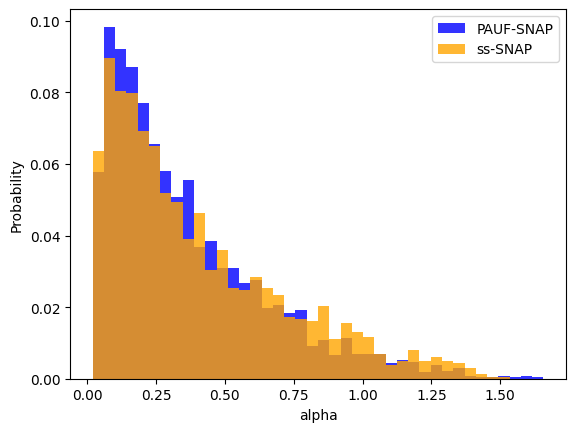

In [26]:
#Representation of both datasets
data1 = np.array(seg_alphas)
data2 = np.array(seg_alphas2)
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
num_bins = min(num_bins1, num_bins2)
#Determine bin edges
min_value = min(data1.min(), data2.min())
max_value = max(data1.max(), data2.max())
bin_edges = np.linspace(min_value, max_value, num_bins + 1)
# Compute histograms to get the counts
counts1, _ = np.histogram(data1, bins=bin_edges)
counts2, _ = np.histogram(data2, bins=bin_edges)
# Calculate the relative probability for each bin
relative_probs1 = counts1 / counts1.sum()
relative_probs2 = counts2 / counts2.sum()
# Plot the histograms
plt.bar(bin_edges[:-1], relative_probs1, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='blue', label='PAUF-SNAP', align='edge')
plt.bar(bin_edges[:-1], relative_probs2, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='orange', label='ss-SNAP', align='edge')
plt.xlabel('alpha')
plt.ylabel('Probability')
plt.legend()

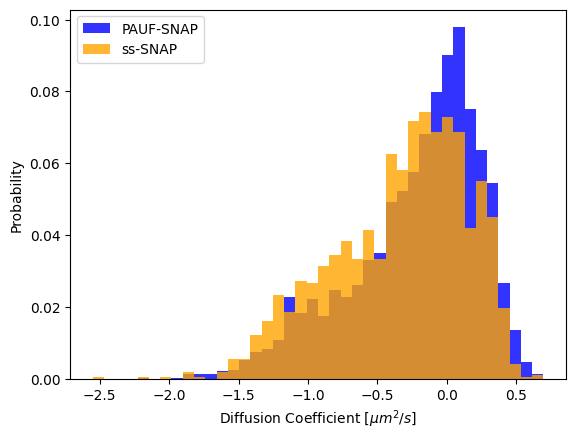

In [27]:
#Representation of both datasets
data1 = np.array(seg_ds)
data2 = np.array(seg_ds2)
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
num_bins = min(num_bins1, num_bins2)
#Determine bin edges
min_value = min(data1.min(), data2.min())
max_value = max(data1.max(), data2.max())
bin_edges = np.linspace(min_value, max_value, num_bins + 1)
# Compute histograms to get the counts
counts1, _ = np.histogram(data1, bins=bin_edges)
counts2, _ = np.histogram(data2, bins=bin_edges)
# Calculate the relative probability for each bin
relative_probs1 = counts1 / counts1.sum()
relative_probs2 = counts2 / counts2.sum()
# Plot the histograms
plt.bar(bin_edges[:-1], relative_probs1, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='blue', label='PAUF-SNAP', align='edge')
plt.bar(bin_edges[:-1], relative_probs2, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='orange', label='ss-SNAP', align='edge')
plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('Probability')
plt.legend()

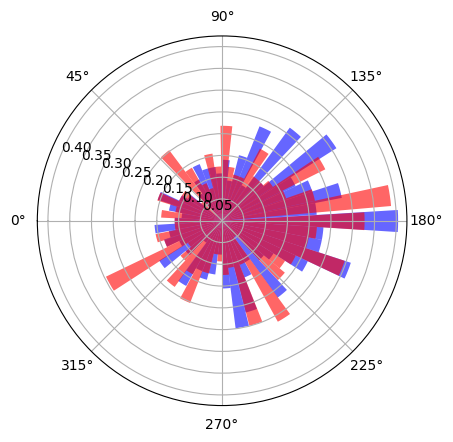

In [63]:
# Angle distribution
fontsize = 22
ticksize = 16

# Prepare the first dataset
angs1 = np.concatenate([a for ang in seg_angs for a in ang if np.isfinite(a).all()])
angs_rad1 = 2 * np.pi * np.array(angs1) / 360  # Convert degrees to radians
hist1, bins1 = np.histogram(angs_rad1, bins=50, density=True)
width1 = np.diff(bins1)

# Prepare the second dataset
angs2 = np.concatenate([a for ang in seg_angs2 for a in ang if np.isfinite(a).all()])
angs_rad2 = 2 * np.pi * np.array(angs2) / 360  # Convert degrees to radians
hist2, bins2 = np.histogram(angs_rad2, bins=50, density=True)
width2 = np.diff(bins2)

# Create a polar subplot
ax = plt.subplot(111, polar=True)
bars1 = ax.bar(bins1[:-1], hist1, width=width1, bottom=0.0, color='blue', alpha=0.6, label='Dataset 1')
bars2 = ax.bar(bins2[:-1], hist2, width=width2, bottom=0.0, color='red', alpha=0.6, label='Dataset 2')
ax.set_theta_zero_location('W')  # Zero degrees at the right
ax.set_theta_direction(-1)  # Clockwise
plt.show()

In [82]:
## Classification and calculation of the probabilities of the data falling into the combinations of specified ranges for both the diffusion 
#coefficient and alpha
#Define bin ranges
dif_coef_bins = [-3, -0.5, 1]  # Ranges for Dif. Coef.
alpha_bins = [0, 0.2, 0.6, 1.5]  # Ranges for alpha

#Data catagorization according to bins
data1 = np.array(seg_ds)
data2 = np.array(seg_alphas)
dif_coef_indices = np.digitize(data1, bins=dif_coef_bins)
alpha_indices = np.digitize(data2, bins=alpha_bins)

# Frequencies for each bin combination
count_matrix = np.zeros((len(dif_coef_bins), len(alpha_bins))) #initialize a 2D array to count frequencies
for i in range(1, len(dif_coef_bins)+1):
    for j in range(1, len(alpha_bins)+1):
        count_matrix[i-1, j-1] = np.sum((dif_coef_indices == i) & (alpha_indices == j))

# Normalize the counts to get probabilities
total_counts = np.sum(count_matrix)
probability_matrix = count_matrix / total_counts
print(len(data1), len(data2))
print(len(pred_d))
print(count_matrix)

301 301
235
[[ 22.  20.   4.   0.]
 [ 73. 129.  53.   0.]
 [  0.   0.   0.   0.]]


In [83]:
# Print probabilities
for i, dif_range in enumerate(zip(dif_coef_bins[:-1], dif_coef_bins[1:])):
    for j, alpha_range in enumerate(zip(alpha_bins[:-1], alpha_bins[1:])):
        print(f"Prob(Dif. Coef. in {dif_range} and alpha in {alpha_range}): {probability_matrix[i, j]:.2f}")

Prob(Dif. Coef. in (-3, -0.5) and alpha in (0, 0.2)): 0.07
Prob(Dif. Coef. in (-3, -0.5) and alpha in (0.2, 0.6)): 0.07
Prob(Dif. Coef. in (-3, -0.5) and alpha in (0.6, 1.5)): 0.01
Prob(Dif. Coef. in (-0.5, 1) and alpha in (0, 0.2)): 0.24
Prob(Dif. Coef. in (-0.5, 1) and alpha in (0.2, 0.6)): 0.43
Prob(Dif. Coef. in (-0.5, 1) and alpha in (0.6, 1.5)): 0.18


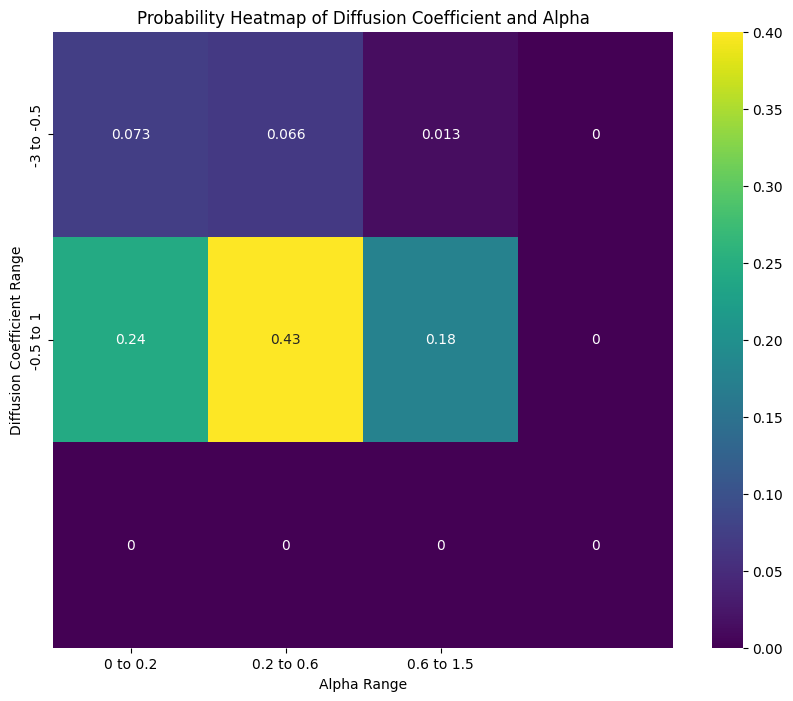

In [84]:
# Visualization
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(probability_matrix, annot=True, cmap="viridis", vmin=0, vmax=0.4, xticklabels=[f"{b[0]} to {b[1]}" for b in zip(alpha_bins[:-1], alpha_bins[1:])],
            yticklabels=[f"{b[0]} to {b[1]}" for b in zip(dif_coef_bins[:-1], dif_coef_bins[1:])])
plt.xlabel("Alpha Range")
plt.ylabel("Diffusion Coefficient Range")
plt.title("Probability Heatmap of Diffusion Coefficient and Alpha")
plt.show()

## Distance to MCS
Step-wise predictions in the context of the MCS distance. 

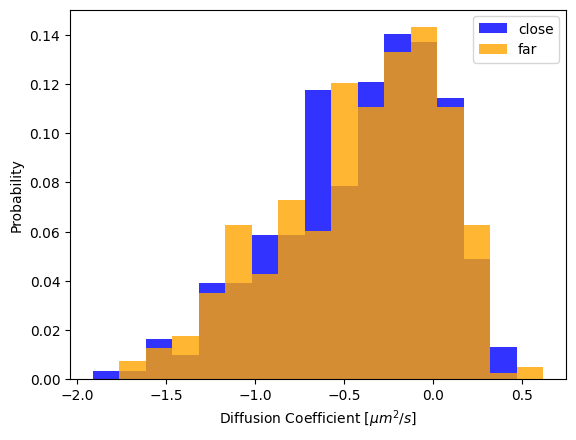

In [105]:
#Filtering of data by close and far, alpha 
data_close, data_far = [], []
for pred, c in zip(seg_ds, location):
    # Boolean indexing
    close_pred = pred[c <= 10]
    far_pred = pred[c > 10]
    # Append the data
    data_close.append(close_pred)
    data_far.append(far_pred)
data1 = np.concatenate(data_close)
data2 = np.concatenate(data_far)

#Representation close and far 1 dataset
#Binning
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
num_bins = min(num_bins1, num_bins2)
#Determine bin edges
min_value = min(data1.min(), data2.min())
max_value = max(data1.max(), data2.max())
bin_edges = np.linspace(min_value, max_value, num_bins + 1)
# Compute histograms without density=True to get the counts
counts1, _ = np.histogram(data1, bins=bin_edges)
counts2, _ = np.histogram(data2, bins=bin_edges)
# Calculate the relative probability for each bin
relative_probs1 = counts1 / counts1.sum()
relative_probs2 = counts2 / counts2.sum()

# Plot the histograms
plt.bar(bin_edges[:-1], relative_probs1, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='blue', label='close')
plt.bar(bin_edges[:-1], relative_probs2, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='orange', label='far')
plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('Probability')
plt.legend()

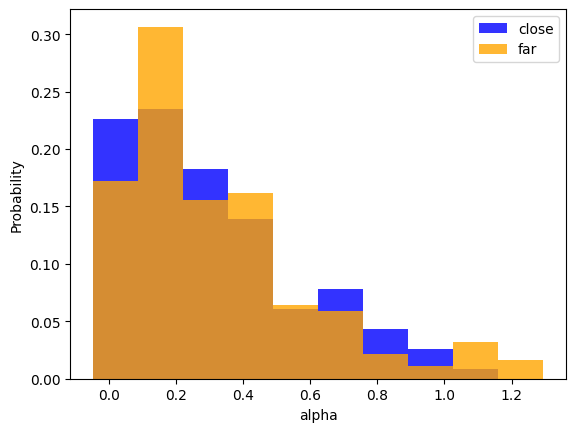

In [86]:
#Filtering of data by close and far, alpha 
data_close, data_far = [], []
for pred, c in zip(seg_alphas, location):
    # Boolean indexing
    close_pred = pred[c <= 10]
    far_pred = pred[c > 10]
    # Append the data
    data_close.append(close_pred)
    data_far.append(far_pred)
data1 = np.concatenate(data_close)
data2 = np.concatenate(data_far)

#Representation close and far 1 dataset
#Binning
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
num_bins = min(num_bins1, num_bins2)
#Determine bin edges
min_value = min(data1.min(), data2.min())
max_value = max(data1.max(), data2.max())
bin_edges = np.linspace(min_value, max_value, num_bins + 1)
# Compute histograms without density=True to get the counts
counts1, _ = np.histogram(data1, bins=bin_edges)
counts2, _ = np.histogram(data2, bins=bin_edges)
# Calculate the relative probability for each bin
relative_probs1 = counts1 / counts1.sum()
relative_probs2 = counts2 / counts2.sum()

# Plot the histograms
plt.bar(bin_edges[:-1], relative_probs1, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='blue', label='close')
plt.bar(bin_edges[:-1], relative_probs2, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='orange', label='far')
plt.xlabel('alpha')
plt.ylabel('Probability')
plt.legend()

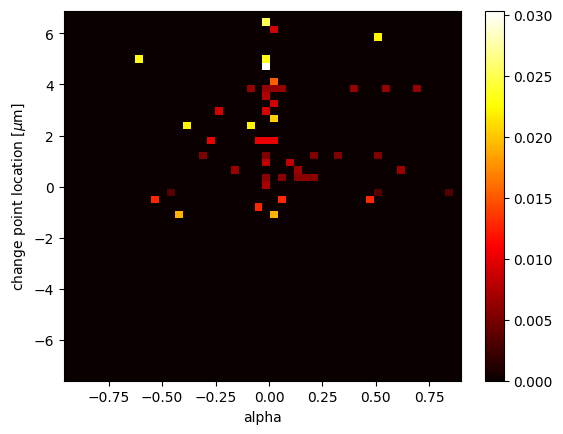

In [88]:
# Relationship diff. coef. change point and distance to MCS
# Process data
data1 = cps_location2 * 0.1567
data2 = jumps_alpha2

# Compute the 2D histogram
#bin_edges_x = np.linspace(np.nanmin(data2), np.nanmax(data2), chosen_bin_size + 1)
#bin_edges_y = np.linspace(np.nanmin(data1), np.nanmax(data1), chosen_bin_size + 1)
hist_2d_1, xedges, yedges = np.histogram2d(data2, data1, bins=[bin_edges_x, bin_edges_y])
hist_2d_1 = hist_2d_1.T

# Normalization by the number of points at each distance (all_close)
# Flatten all tensors in all_close and convert to a single NumPy array
all_close_flat = np.concatenate([c.numpy().flatten() for c in all_close2]) * 0.1567
counts, _ = np.histogram(all_close_flat, bins=bin_edges_y)
hist_2d_normalized2 = np.array([row / count if count > 0 else row for row, count in zip(hist_2d_1, counts)])

#Plot
plt.imshow(hist_2d_normalized2, cmap='hot', interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.xlabel('alpha')
plt.ylabel('change point location [$\mu$m]')
#plt.ylim(-10, 40)
plt.colorbar()
plt.gca().set_aspect('auto')
plt.show()

In [92]:
#Plot by distance to MCS
alpha_bins = [0, 0.2, 0.6, 1.5]
alpha_labels = ['confined', 'subdiffusive', 'Brownian']
dif_coef_bins = [-3, -0.5, 1]
dif_coef_labels = ['slow', 'fast']

def classify_predictions(alphas, ds):
    alpha_indices = np.digitize(alphas, alpha_bins) - 1
    ds_indices = np.digitize(ds, dif_coef_bins) - 1
    groups = []
    for a_idx, d_idx in zip(alpha_indices, ds_indices):
        alpha_part = alpha_labels[a_idx] if 0 <= a_idx < len(alpha_labels) else 'Unknown'
        dif_part = dif_coef_labels[d_idx] if 0 <= d_idx < len(dif_coef_labels) else 'Unknown'
        group = f"{alpha_part}-{dif_part}" if 'Unknown' not in (alpha_part, dif_part) else 'Unknown'
        groups.append(group)
    return groups

In [87]:
# Classify by segments
data1 = location2 * 0.1567  # Convert to micrometers
data2 = seg_alphas2  # Alpha values
data3 = seg_ds2      # Diffusion coefficients

groups = classify_predictions(data2, data3)

# Assuming you have already classified your predictions
groups = classify_predictions(data2, data3)

# Create DataFrame
df = pd.DataFrame({
    'Value': data1,
    'Group': groups
    })

# Remove entries classified as 'Unknown'
df = df[df['Group'] != 'Unknown']

# Optionally, re-establish the categorical type for plotting if needed
unique_groups = sorted(set(df['Group']))  # Update unique groups after filtering
df['Group'] = pd.Categorical(df['Group'], categories=unique_groups, ordered=True)

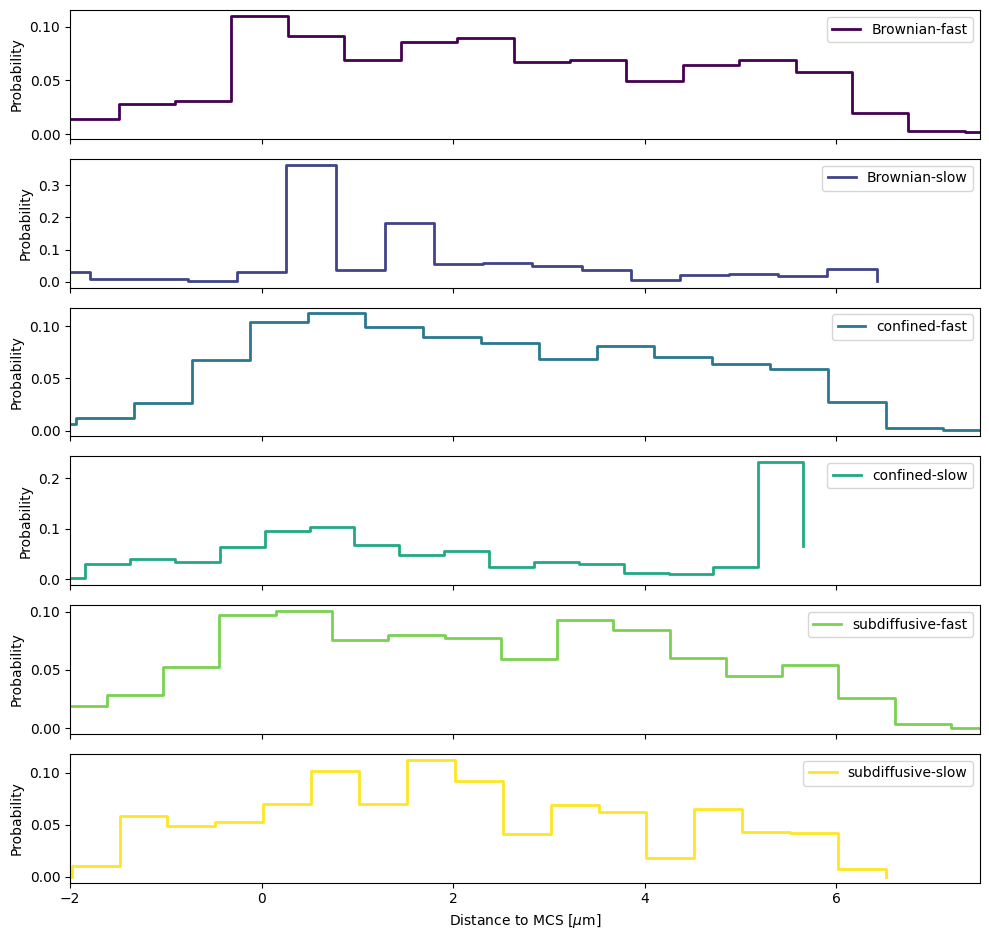

In [107]:
# Setup the colors and plot
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_groups)))
fig, axes = plt.subplots(nrows=len(unique_groups), figsize=(10, 10), sharex=True)
if len(unique_groups) == 1:
    axes = [axes]

for ax, (group, color) in zip(axes, zip(unique_groups, colors)):
    subset = df[df['Group'] == group]['Value']
    counts, bins = np.histogram(subset, bins=30)  # Adjust bin count as needed
    probabilities = counts / counts.sum()
    ax.step(bins[:-1], probabilities, where='post', color=color, label=f"{group}", linewidth=2)
    ax.set_ylabel('Probability')
    ax.legend(loc='upper right')

plt.xlabel('Distance to MCS [$\mu$m]')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.xlim(-2,7.5)
plt.show()


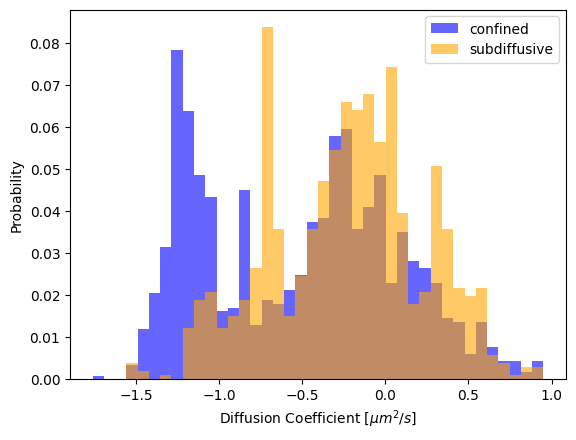

In [50]:
#Dif. coef. of highly confined trajectories (0 to 0.2)
data_confined, data_subd = [], []
for preda, predd in zip(pred_a2, pred_d2):
    preda = preda[:-1]
    # Bolean indexing
    conf = predd[preda < 0.2]
    subd = predd[(preda > 0.2) & (preda < 0.6)]
    #Append the data
    data_confined.append(conf)
    data_subd.append(subd)
data_confined = torch.cat(data_confined).numpy()
data_subd = torch.cat( data_subd).numpy()
#Representation close and far 1 dataset
#Determine number of bins
num_bins1 = int(np.sqrt(len(data_confined)))
num_bins2 = int(np.sqrt(len(data_subd)))
num_bins = min(num_bins1, num_bins2)
#Determine bin edges
min_value = min(data_confined.min(), data_subd.min())
max_value = max(data_confined.max(), data_subd.max())
bin_edges = np.linspace(min_value, max_value, num_bins + 1)
# Compute histograms without density=True to get the counts
counts1, _ = np.histogram(data_confined, bins=bin_edges)
counts2, _ = np.histogram(data_subd, bins=bin_edges)
# Calculate the relative probability for each bin
relative_probs1 = counts1 / counts1.sum()
relative_probs2 = counts2 / counts2.sum()
# Plot the histograms
plt.bar(bin_edges[:-1], relative_probs1, width=bin_edges[1] - bin_edges[0], alpha=0.6, color='blue', label='confined', align='edge')
plt.bar(bin_edges[:-1], relative_probs2, width=bin_edges[1] - bin_edges[0], alpha=0.6, color='orange', label='subdiffusive', align='edge')
plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
#plt.ylim(0, 0.11)
plt.ylabel('Probability')
plt.legend()
plt.show()